In [1]:
import os
import pandas as pd
import pickle, json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dl_portfolio.data import load_data
from dl_portfolio.utils import load_result, load_result_wrapper
import sys
import itertools
from sklearn.neighbors import KernelDensity
from scipy.stats import pearsonr, spearmanr, kendalltau
import warnings
%matplotlib inline

# Some useful functions

In [2]:
def plt_features(features,  start, end, dataset, savepath=None):
    if dataset == "dataset1":
        nrow, ncol = 2,2
        figsize=(12,10)
    elif dataset == "dataset2":
        nrow, ncol = 2,3
        figsize=(18,10)
        
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize, sharex=True, sharey=True)
    for i, c in enumerate(features["ae"].columns):
        temp = features["ae"].loc[start:end]
        if i % ncol == 0:
            if i > 0:
                row = 1
            else:
                row = 0
        col = i % ncol

        min_ = np.min(temp[c]) - 1
        max_ = np.max(temp[c]) + 1
        X_plot = np.linspace(min_, max_, 1000)[:, np.newaxis]
        kde = KernelDensity(kernel='gaussian', bandwidth=0.4).fit(np.random.normal(size=1000).reshape(-1,1))
        norm_log_dens = kde.score_samples(X_plot)

        axs[row, col].plot(X_plot[:, 0], np.exp(norm_log_dens), label='normal', color="green")

        kde = KernelDensity(kernel='gaussian', bandwidth=0.4).fit(temp[c].values.reshape(-1,1))
        log_dens = kde.score_samples(X_plot)

        _ = axs[row, col].hist(temp[c], bins = 50, density=True, alpha=0.25, 
                               histtype='stepfilled',  edgecolor='none', color="blue")
        axs[row, col].plot(X_plot[:, 0], np.exp(log_dens), label='ae', color="blue")
        if savepath is None:
            axs[row, col].legend()
            axs[row, col].set_title(c)
        
        
        temp = features["nmf"].loc[start:end]
        
        min_ = np.min(temp[c]) - 1
        max_ = np.max(temp[c]) + 1
        X_plot = np.linspace(min_, max_, 1000)[:, np.newaxis]
        kde = KernelDensity(kernel='gaussian', bandwidth=0.4).fit(temp[c].values.reshape(-1,1))
        log_dens = kde.score_samples(X_plot)

        _ = axs[row, col].hist(temp[c], bins = 50, density=True, alpha=0.25,
                               histtype='stepfilled',  edgecolor='none', color="purple")
        axs[row, col].plot(X_plot[:, 0], np.exp(log_dens), label='nmf', color="purple")
        if savepath is None:
            axs[row, col].legend()
            axs[row, col].set_title(c)
        axs[row, col].set_xlim(-10,10)
        
    if dataset == "dataset2":
        axs[1,2].remove()

    plt.subplots_adjust(hspace = .1)
    plt.subplots_adjust(wspace = .1)

    if savepath:
        plt.savefig(savepath, bbox_inches='tight', transparent=True)

def plot_factor_corr(components, c1, c2, assets, t =0.05, components2 = None, show=False, unit_circle=False, 
                     title=None, savepath=None, ax = None):
    
    if ax is None:
        (fig, ax) = plt.subplots(figsize=(20, 20))
    ax.plot([-1,1], [0, 0], '--', c='black')
    ax.plot([0,0], [-1,1], '--', c='black')
    
    for i in range(0, len(assets)):
        if components[c1, i] > t or components[c2, i] > t:
            ax.arrow(0,
                     0,  # Start the arrow at the origin
                     components[c1, i],  #0 for PC1
                     components[c2, i],  #1 for PC2
                     # width = 0.01, # float, default: 0.001
                     head_width=0.025,
                     head_length=0.025, 
                     color='b')
            ax.text(components[c1, i] + 0.02,
                     components[c2, i] + 0.02,
                     assets[i],
                    size=15,
                    c='b')
            
    if components2 is not None:
        for i in range(0, len(assets)):
            if components2[c1, i] > t or components2[c2, i] > t:
                ax.arrow(0,
                         0,  # Start the arrow at the origin,
                         components2[c1, i],  #0 for PC1
                         components2[c2, i],  #1 for PC2
                         # width = 0.01, # float, default: 0.001
                         head_width=0.025,
                         head_length=0.025,
                         color='r')
                ax.text(components2[c1, i] + 0.02,
                        components2[c2, i] + 0.02,
                        assets[i],
                    size=15,
                        c='r')

    if unit_circle:
        an = np.linspace(0, 2 * np.pi, 100)
        ax.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
        ax.axis('equal')
    else:
        ax.xlim([-0.05, 1])
        ax.ylim([-0.05, 1])

    if title:
        ax.set_title(title)
    else:
        ax.set_title('Variable factor map')
    
    if ax is None:
        ax.set_xlabel(f'dim {c1}')
        ax.set_ylabel(f'dim {c2}')

    ax.set(adjustable='box', aspect='equal')
    
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', transparent=False)
    if show:
        plt.show()
        
def get_corr_factor_asset(test_data, features, corr="pearson"):
    if corr == "pearson":
        corr_measure = pearsonr
    elif corr == "spearman":
        corr_measure = spearmanr
    elif corr == "kendall":
        corr_measure = kendalltau
    else:
        raise NotImplementedError()
        
    corr_asset_factor = pd.DataFrame(index = test_data.columns, columns = features.columns)
    for c in features.columns:
        for a in test_data.columns:
            corr_asset_factor.loc[a, c], p_value = corr_measure(test_data[a], features[c])
            if p_value >= 0.05:
                corr_asset_factor.loc[a, c] = 0
    return corr_asset_factor

def intrepretation_plot(test_data, features, dataset, labels, corr="pearson", savepath=None):
    pairs = list(itertools.combinations(labels, 2))
    ind_pairs = list(itertools.combinations(list(range(len(labels))), 2))

    corr_ae = get_corr_factor_asset(test_data, features["ae"], corr=corr)
    corr_nmf = get_corr_factor_asset(test_data, features["nmf"], corr=corr)


    if dataset == "dataset1":
        figsize = (15,10)
        nrow=2
        ncol=3
        h_space=0.1
        w_space=0.01
    else:
        nrow=2
        ncol=5
        figsize = (20,10)
        h_space=0.
        w_space=0.05
        
    fig, axs = plt.subplots(nrow, ncol, figsize = figsize, sharex=True, sharey=True)

    col = 0
    row = -1
    for i, dims in enumerate(ind_pairs):
        if i % ncol == 0:
            row +=1
        if i >= ncol:
            col = i - ncol
        else:
            col = i
        dim1=dims[0]
        dim2=dims[1]
        name1=pairs[i][0]
        name2=pairs[i][1]
        plot_factor_corr(corr_ae.values.T, dim1, dim2, assets, t=0, components2=corr_nmf.T.values, 
                         title = f"{name2} vs {name1}",
                         unit_circle=True, savepath=None, ax = axs[row,col])
    fig.subplots_adjust(hspace=h_space, wspace=w_space)
    
    if savepath is not None:
        fig.savefig(savepath, bbox_inches='tight', transparent=True)

# Input: set datatset name ("dataset1" or "dataset2")

In [3]:
DATASET = 'dataset1'

# Save directory

In [4]:
SAVE = True
savedir = "paper_result"
if SAVE:
    if not os.path.isdir(savedir):
        os.mkdir(savedir)


# Load results

In [ ]:
test_set = 'test'
if DATASET == 'dataset1':
    LABELS = ["Bond", "Stock", "Forex", "Crypto"]
    ae_base_dir = "final_models/ae/dataset1/m_0_dataset1_nbb_resample_bl_60_seed_0_1647953383912806"
    nmf_base_dir = "final_models/nmf/dataset1/m_0_seed_7_20220322_122627"
    perf_ae_dir = "./performance/test_final_models/ae/dataset1_20220322_150317"
    perf_nmf_dir = "./performance/test_final_models/nmf/dataset1_20220322_145318"
elif DATASET == 'dataset2':
    LABELS = ["US Stocks", "Other Stocks", "Commodities", "US Bond", "FR Bond"]
    ae_base_dir = "./final_models/ae/dataset2/m_4_dataset2_nbb_resample_bl_60_seed_0_1647957514122232"
    nmf_base_dir = "./final_models/nmf/dataset2/m_0_seed_4_20220322_123053"
    perf_ae_dir = "./performance/test_final_models/ae/dataset2_20220323_152418"
    perf_nmf_dir = "./performance/test_final_models/nmf/dataset2_20220322_151938"
else:
    raise NotImplementedError()

# Load evaluation
ae_test_eval = json.load(open(f'{perf_ae_dir}/evaluation.json', 'r'))
nmf_test_eval = json.load(open(f'{perf_nmf_dir}/evaluation.json', 'r'))
ae_port_weight = pickle.load(open(f"{perf_ae_dir}/portfolios_weights.p", "rb"))

# Load results
sys.path.append(ae_base_dir)
import ae_config
sys.path.append(nmf_base_dir)
import nmf_config
test_data = pd.DataFrame()
prediction = {"ae": pd.DataFrame(), "nmf": pd.DataFrame()}
features = {"ae": pd.DataFrame(), "nmf": pd.DataFrame()}
residuals = {"ae": pd.DataFrame(), "nmf": pd.DataFrame()}
embedding = {}
decoding = {}
data, assets = load_data(dataset=ae_config.dataset)

warnings.filterwarnings(action='ignore')
test_data, prediction["ae"], features["ae"], residuals["ae"], embedding["ae"], decoding["ae"], relu_activation= load_result_wrapper(ae_config,
                                                                                                    test_set, 
                                                                                                    data,
                                                                                                    assets,
                                                                                                    ae_base_dir)


_, prediction["nmf"], features["nmf"], residuals["nmf"], embedding["nmf"], decoding["nmf"], _ = load_result_wrapper(nmf_config,
                                                                                                    test_set, 
                                                                                                    data,
                                                                                                    assets,
                                                                                                    nmf_base_dir)

# Factors
## Explainability

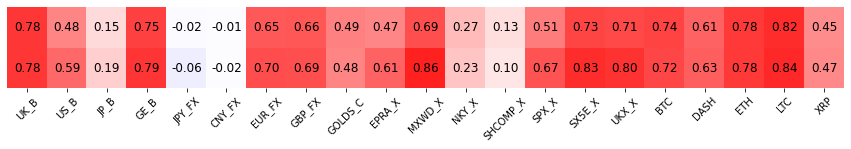

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(15,1.5), sharex=True)
r2 = pd.DataFrame(ae_test_eval['model']['r2'].values(), index = ae_test_eval['model']['r2'].keys()).T
if DATASET == "dataset1":
    vmin = np.min(r2.values) - np.std(r2.values)
    center = 0
else:
    vmin=np.min(r2.values)
    center=np.min(r2.values) - np.std(r2.values)
sns.heatmap(r2,
            vmin=vmin,
            center=center,
            vmax=1, 
            annot=True,
            yticklabels=False,
            fmt='.2f',
            annot_kws={'color': 'black', 'size': 'large', 'ha': 'center'},
            cmap='bwr',
            cbar=False,
            ax=axs[0]) # cmap='Reds')

r2 = pd.DataFrame(nmf_test_eval['model']['r2'].values(), index = nmf_test_eval['model']['r2'].keys()).T
if DATASET == "dataset1":
    vmin = np.min(r2.values) - np.std(r2.values)
    center = 0
else:
    vmin=np.min(r2.values)
    center=np.min(r2.values) - np.std(r2.values)
sns.heatmap(r2,
            vmin=vmin,
            center=center,
            vmax=1, 
            annot=True,
            yticklabels=False,
            fmt='.2f',
            cmap='bwr',
            annot_kws={'color': 'black', 'size': 'large', 'ha': 'center'},
            cbar=False,
            ax=axs[1]) # cmap='Reds')
plt.subplots_adjust(hspace = .0)
axs[1].tick_params(axis='x', labelrotation = 45,  labelsize=10)
if SAVE:
    plt.savefig(f'{savedir}/r2_heatmap_{DATASET}.png', bbox_inches='tight', transparent=True)

## Interpretation

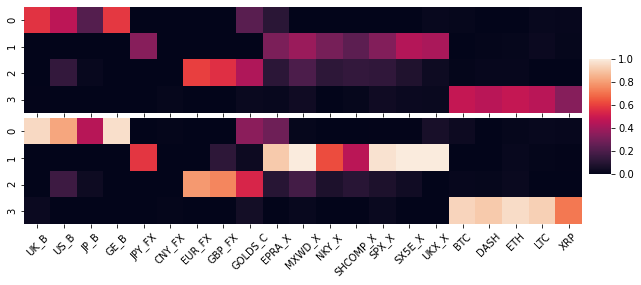

In [7]:
ae_loadings = np.array([decoding["ae"][k].values for k in decoding["ae"].keys()])
ae_avg_loadings = pd.DataFrame(ae_loadings.mean(0), index=assets)

w = decoding["nmf"][0].copy()
w = w /np.sqrt(np.sum(w**2))
(w**2).sum()


nmf_loadings = np.array([decoding["nmf"][k].values for k in decoding["nmf"].keys()])
nmf_avg_loadings = pd.DataFrame(nmf_loadings.mean(0), index=assets)


if DATASET == "dataset1":
    figsize=(10,4)
elif DATASET == "dataset2":
    figsize=(10,6)
fig, axs = plt.subplots(2, 1, figsize=figsize, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
sns.heatmap(ae_avg_loadings.T, vmin=0, vmax=1, ax=axs[0], cbar=False)
sns.heatmap(nmf_avg_loadings.T, vmin=0, vmax=1, ax=axs[1], cbar=True, cbar_ax=cbar_ax)
plt.subplots_adjust(hspace = 0.05)
axs[1].tick_params(axis='x', labelrotation = 45,  labelsize=10)
if SAVE:
    plt.savefig(f'{savedir}/loading_avg_heatmap_{DATASET}.png', bbox_inches='tight', transparent=True)

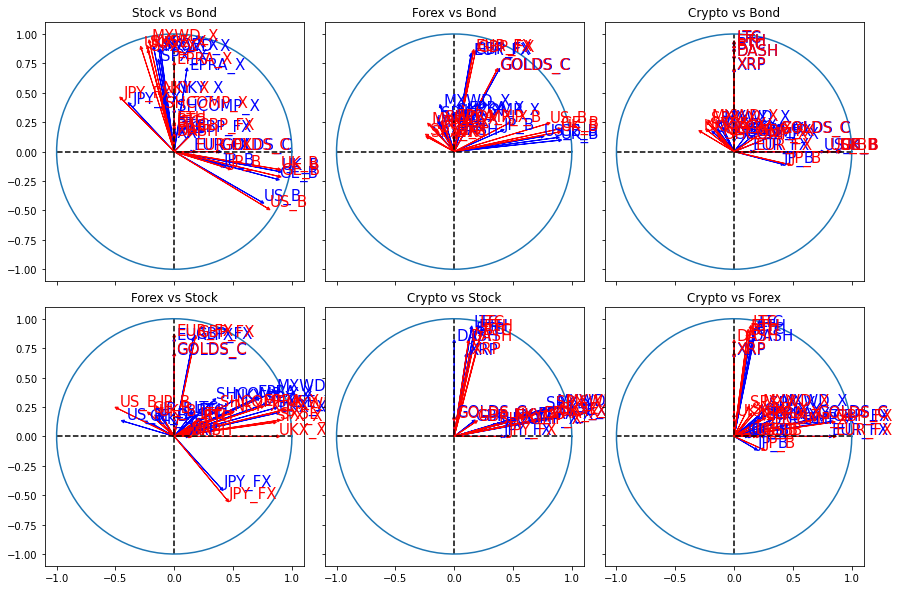

In [8]:
if SAVE:
    savepath = f'{savedir}/corr_asset_factor_{DATASET}.png'
else:
    savepath = None
intrepretation_plot(test_data,
                    features, 
                    DATASET,
                    LABELS,
                    savepath=savepath,
                    corr="pearson")

## Factors distribution

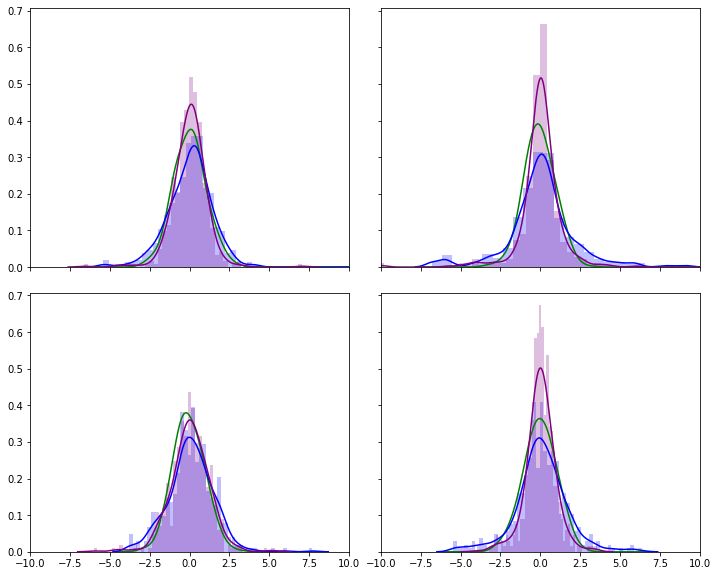

In [9]:
if SAVE:
    savepath=f'{savedir}/factor_distribution_{DATASET}.png'
else:
    savepath = None
    
start = features["ae"].index[0]
end = features["ae"].index[-1]
plt_features(features, start, end, DATASET, savepath=savepath)
